In [1]:
%cd ..

/home/juanhevia/IDIL


In [2]:
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt 
import os 

RESULTS_PATH="./idil_train/result/"

# Read model instance from `wandb`

Get global configuration file.

Be aware many parameters should be update to match specific run configs (i.e. `k` param)

In [3]:
from idil_algs.IDIL.agent.mental_iql import MentalIQL
from munch import Munch
import yaml


available_envs = os.listdir(RESULTS_PATH)
env_name = available_envs[0]
print(f"Using env: {env_name}")

# list available wandb runs
# os.listdir(os.path.join(RESULTS_PATH, env_name, 'idil'))

RUN_PATH = os.path.join(RESULTS_PATH, env_name, 'idil',
                         'disc-es-0-01J22ESV2R9PZCJE60KMHG3HG8',
                         '2024-07-05_17-03-59')
print(f"Using run: {RUN_PATH}")

with open(os.path.join(RUN_PATH, 'log', 'config.yaml') , "r") as f:
    run_conf = yaml.load(f, Loader=yaml.FullLoader)
    run_conf = Munch(run_conf)

# load the model
miql_agent = MentalIQL(config=run_conf,
                       obs_dim=1026, action_dim=6, lat_dim=run_conf["dim_c"], # obs dim and action dim are hardcoded for now, they belogn to CleanupSingle
                       discrete_obs=True, discrete_act=True)

prefix = os.listdir(os.path.join(RUN_PATH, 'model'))[0].split("_pi")[0]

miql_agent.load(os.path.join(RUN_PATH, 'model', prefix))

Using env: CleanupSingle-v0
Using run: ./idil_train/result/CleanupSingle-v0/idil/disc-es-0-01J22ESV2R9PZCJE60KMHG3HG8/2024-07-05_17-03-59
Loading models from ./idil_train/result/CleanupSingle-v0/idil/disc-es-0-01J22ESV2R9PZCJE60KMHG3HG8/2024-07-05_17-03-59/model/iq_CleanupSingle-v0_n50_l0_best_tx
Loading models from ./idil_train/result/CleanupSingle-v0/idil/disc-es-0-01J22ESV2R9PZCJE60KMHG3HG8/2024-07-05_17-03-59/model/iq_CleanupSingle-v0_n50_l0_best_pi


In [4]:
run_conf.env_name

'CleanupSingle-v0'

# Get intent prediction accuracy

In [5]:
from idil_algs.baselines.IQLearn.dataset.expert_dataset import (ExpertDataset)



def load_expert_data_w_labels(demo_path, num_trajs, n_labeled, seed):
  expert_dataset = ExpertDataset(demo_path, num_trajs, 1, seed + 42)
  print(f'--> Expert memory size: {len(expert_dataset)}')

  cnt_label = 0
  traj_labels = []
  for i_e in range(num_trajs):
    if "latents" in expert_dataset.trajectories:
      expert_latents = expert_dataset.trajectories["latents"][i_e]
    else:
      expert_latents = None

    if i_e < n_labeled:
      traj_labels.append(expert_latents)
      cnt_label += 1
    else:
      traj_labels.append(None)

  print(f"num_labeled: {cnt_label} / {num_trajs}, num_samples: ",
        len(expert_dataset))
  return expert_dataset, traj_labels, cnt_label

expert_dataset, traj_labels, cnt_label = load_expert_data_w_labels(demo_path=os.path.join('idil_train', run_conf['data_path']),
                                                                    num_trajs=run_conf['n_traj'],
                                                                    n_labeled=run_conf['n_traj'], # use all trajectory labels
                                                                    seed=42,)

--> Expert memory size: 2315
num_labeled: 50 / 50, num_samples:  2315


In [6]:
expert_dataset.trajectories.keys()

dict_keys(['states', 'next_states', 'actions', 'latents', 'rewards', 'dones', 'lengths'])

In [7]:
len(expert_dataset.trajectories['states']) # 50 trajectories
num_trajs = len(expert_dataset.trajectories['states'])

for i in range(5):
    print(f"Trajectory {i} has")
    print(f"States: {len(expert_dataset.trajectories['states'][i])}")
    print(f"Actions: {len(expert_dataset.trajectories['actions'][i])}")
    print(f"Rewards: {len(expert_dataset.trajectories['rewards'][i])}")
    print(f"Latents: {len(expert_dataset.trajectories['latents'][i])}")

Trajectory 0 has
States: 42
Actions: 42
Rewards: 42
Latents: 42
Trajectory 1 has
States: 41
Actions: 41
Rewards: 41
Latents: 41
Trajectory 2 has
States: 51
Actions: 51
Rewards: 51
Latents: 51
Trajectory 3 has
States: 44
Actions: 44
Rewards: 44
Latents: 44
Trajectory 4 has
States: 48
Actions: 48
Rewards: 48
Latents: 48


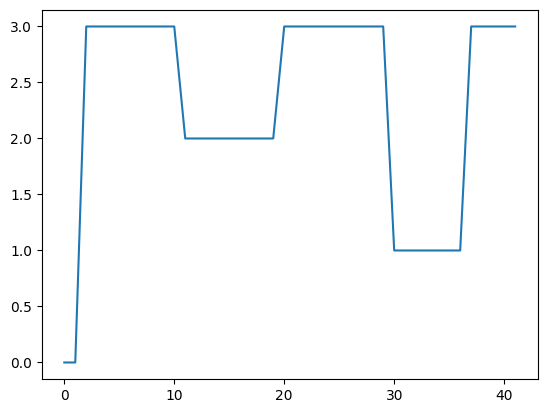

In [8]:
_latent = expert_dataset.trajectories['latents'][0]
plt.plot(_latent)

In [9]:
_sample_states = expert_dataset.trajectories['states'][0]
_sample_actions = expert_dataset.trajectories['actions'][0]

len(_sample_states), len(_sample_actions)

(42, 42)

In [10]:
_infer_intents, log_probs, entropy  = miql_agent.infer_mental_states(_sample_states, _sample_actions)

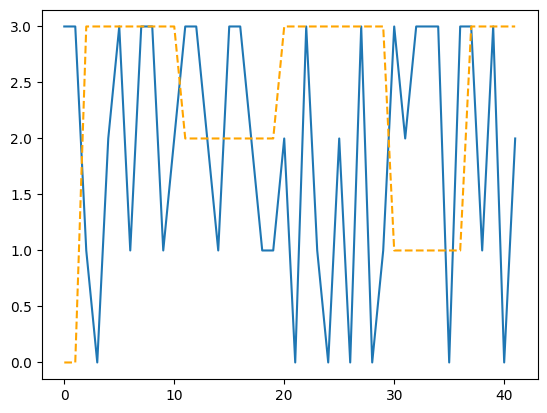

In [11]:
plt.plot(_infer_intents.squeeze(1))
plt.plot(_latent, color="orange", linestyle="--")

In [12]:
def compute_sequence_accuracy(pred_latents, true_latents):
    pred_latents = np.array(pred_latents)
    true_latents = np.array(true_latents)
    return np.sum(pred_latents == true_latents) / len(true_latents)

compute_sequence_accuracy(_infer_intents.squeeze(1), _latent)

0.21428571428571427

In [13]:
# compute accuracy for all trajectories
accs = []
for i in range(num_trajs):
    _sample_states = expert_dataset.trajectories['states'][i]
    _sample_actions = expert_dataset.trajectories['actions'][i]
    _latent = expert_dataset.trajectories['latents'][i]

    _infer_intents, log_probs, entropy  = miql_agent.infer_mental_states(_sample_states, _sample_actions)
    accs.append(compute_sequence_accuracy(_infer_intents.squeeze(1), _latent))

np.mean(accs)

0.3059544352177094

In [14]:
np.std(accs)

0.06311693921503875

# loading envs

In [15]:
import idil_gym # register the environment
from idil_algs.baselines.IQLearn.utils.utils import (make_env, eval_mode,
                                                     compute_expert_return_mean)

sample_env = make_env("CleanupSingle-v0")

In [16]:
import gym

In [17]:
import gym

def get_run_path(env_name: str, run_id: str):
    """
    Get the path where we store 'model' and 'log' data for a given run
    """
    # read one dir below, as there is always a date directory
    _path = os.path.join(RESULTS_PATH, env_name, 'idil', run_id)
    _date_folder = os.listdir(_path)[0]
    return os.path.join(_path, _date_folder)

def get_run_config(run_path:str):
    """
    Parse run YAML configuration and return as Munch dictioanry object
    """

    with open(os.path.join(run_path, 'log', 'config.yaml') , "r") as f:
        run_conf = yaml.load(f, Loader=yaml.FullLoader)
        run_conf = Munch(run_conf)
    return run_conf

def get_agent(run_path: str, run_conf: Munch):
    """
    Load the agent from the run path
    """
    # load env
    env = make_env(run_conf.env_name)

    _obs_space_dim = env.observation_space.n if isinstance(env.observation_space, gym.spaces.Discrete) else env.observation_space.shape[0]
    _act_space_dim = env.action_space.n if isinstance(env.action_space, gym.spaces.Discrete) else env.action_space.shape[0]    

    miql_agent = MentalIQL(config=run_conf,
                           obs_dim=_obs_space_dim,
                           action_dim=_act_space_dim,
                           lat_dim=run_conf.dim_c, # obs dim and action dim are hardcoded for now, they belogn to CleanupSingle
                           discrete_obs=isinstance(env.observation_space, gym.spaces.Discrete),
                           discrete_act=isinstance(env.action_space, gym.spaces.Discrete))

    prefix = os.listdir(os.path.join(run_path, 'model'))[0].split("_pi")[0]

    miql_agent.load(os.path.join(run_path, 'model', prefix))
    return miql_agent

In [18]:
ENV_NAME = "CleanupSingle-v0"

run_path = get_run_path(ENV_NAME, 'disc-es-0-01J2FAJX0XX4X23F749XRY6EQV')
run_config = get_run_config(run_path)
miql_agent = get_agent(run_path, run_config)

Loading models from ./idil_train/result/CleanupSingle-v0/idil/disc-es-0-01J2FAJX0XX4X23F749XRY6EQV/2024-07-10_17-00-25/model/iq_CleanupSingle-v0_n50_l0_best_tx
Loading models from ./idil_train/result/CleanupSingle-v0/idil/disc-es-0-01J2FAJX0XX4X23F749XRY6EQV/2024-07-10_17-00-25/model/iq_CleanupSingle-v0_n50_l0_best_pi


# Test loading test trajectories

In [19]:
run_config.n_traj

50

In [20]:
expert_dataset, traj_labels, cnt_label = load_expert_data_w_labels(
    demo_path=os.path.join('idil_train', run_config.data_path),
    num_trajs=run_config.n_traj * 2,
    n_labeled=run_config.n_traj, # use all trajectory labels
    seed=42,)

--> Expert memory size: 4693
num_labeled: 50 / 100, num_samples:  4693


In [21]:
os.listdir(os.path.join('idil_train', "test_data"))

['CleanupSingle-v0_50.pkl',
 'MultiGoals2D_2-v0_50.pkl',
 'EnvMovers-v0_22.pkl',
 'MultiGoals2D_4-v0_50.pkl',
 'MultiGoals2D_5-v0_50.pkl',
 'MultiGoals2D_3-v0_50.pkl']

In [22]:
import pickle as pkl

with open(os.path.join('idil_train', "test_data", "CleanupSingle-v0_50.pkl"), "rb") as f:
    test_data = pkl.load(f)

len(test_data["states"])

50

In [23]:
test_data["states"][0][:10]

[351, 486, 486, 675, 648, 783, 891, 972, 999, 1000]

In [24]:
expert_dataset.trajectories["states"][0][:10]

[27, 0, 9, 9, 9, 198, 387, 414, 549, 576]

In [25]:
import pickle as pkl

with open(os.path.join('idil_train', "experts", "CleanupSingle-v0_100.pkl"), "rb") as f:
    train_data = pkl.load(f)

len(train_data["states"])

100

In [26]:
len(train_data["latents"])
all([len(l) > 0 for l in train_data["latents"]])

True

In [27]:
import pickle as pkl

with open(os.path.join('idil_train', "experts", "MultiGoals2D_3-v0_500.pkl"), "rb") as f:
    train_data = pkl.load(f)

len(train_data["states"])

500

# Plot trajectories in `CleanupSingle`

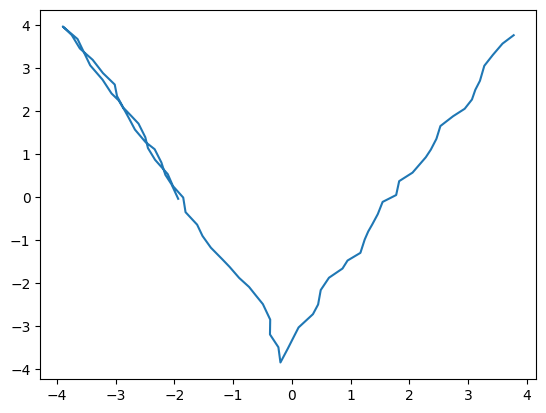

In [28]:
_traj = train_data["states"][0]

_x = np.array(_traj)[:, 0]
_y = np.array(_traj)[:, 1]

plt.plot(_x, _y)

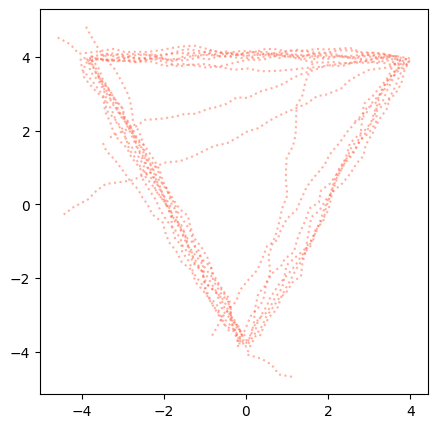

In [34]:
def plot_traj(trajectory, ax=None, **plot_kwargs):
    _arr_traj = np.array(trajectory)
    
    _x = _arr_traj[:, 0]
    _y = _arr_traj[:, 1]
    ax.plot(_x, _y, **plot_kwargs)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i in range(10):
    plot_traj(train_data["states"][i], ax=ax, color="tomato", alpha=0.5, ls="dotted")

In [30]:
from idil_algs.IDIL_Joint.helper.utils import evaluate

In [31]:
env = make_env("CleanupSingle-v0")

returns, timesteps, successes = evaluate(miql_agent, env, num_episodes=60)

In [33]:
# get sample predicted trajectories
from idil_algs.IDIL.utils import DiscreteExpertPolicySampler

expert_dataset, traj_labels, cnt_label = load_expert_data_w_labels(
    demo_path=os.path.join('idil_train', run_config.data_path),
    num_trajs=run_config.n_traj,
    n_labeled=run_config.n_traj, # use all trajectory labels
    seed=42,)

expert_sampler = DiscreteExpertPolicySampler(expert_dataset, device="cpu")

--> Expert memory size: 2315
num_labeled: 50 / 50, num_samples:  2315


In [54]:
from collections import defaultdict

# get comparison between expert and agent trajectories
def compute_trajectory_comparison(expert_sampler, agent, env, max_traj_len=50):
    """
    Given the same start state and action, compute two dictionaries,
    one for expert trajectories and one for agent trajectories,
    where keys are state and actions and values are the corresponding attributes at 
    each timestep
    """

    expert_trajs = defaultdict(list)
    agent_trajs = defaultdict(list)
    
    done = False
    state = env.reset()
    prev_latent, prev_action = agent.PREV_LATENT, agent.PREV_ACTION

    max_traj_len = min(10_000_000, max_traj_len)
    
    # get agent trajectory
    with eval_mode(agent):
        while not done:
            latent, action = agent.choose_action(state,
                                        prev_latent,
                                        prev_action,
                                        sample=False)
            next_state, reward, done, info = env.step(action)
            state = next_state
            prev_latent = latent
            prev_action = action

            agent_trajs["states"].append(state)
            agent_trajs["actions"].append(action)
            agent_trajs["rewards"].append(reward)
            agent_trajs["latents"].append(latent)

            if len(agent_trajs["states"]) >= max_traj_len:
                done = True
        
    # get expert trajectory
    done = False
    state = env.reset()
    prev_latent, prev_action = agent.PREV_LATENT, agent.PREV_ACTION
    while not done:
        latent = agent.choose_mental_state(state, prev_latent)
        action = expert_sampler.choose_action(state, prev_latent, prev_action)
        next_state, reward, done, info = env.step(action)
        state = next_state
        prev_latent = latent
        prev_action = action

        expert_trajs["states"].append(state)
        expert_trajs["actions"].append(action)
        expert_trajs["rewards"].append(reward)
        expert_trajs["latents"].append(latent)

        if len(expert_trajs["states"]) >= max_traj_len:
            done = True

    return expert_trajs, agent_trajs

In [55]:
_sample_expert_traj, _sample_agent_traj = compute_trajectory_comparison(expert_sampler, miql_agent, env, max_traj_len=10)

In [56]:
_sample_agent_traj

defaultdict(list,
            {'states': [702, 702, 729, 729, 756, 729, 567, 540, 405, 216],
             'actions': [3, 4, 1, 1, 1, 0, 2, 0, 2, 2],
             'rewards': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
             'latents': [1, 1, 0, 1, 3, 1, 3, 0, 0, 3]})

In [57]:
_sample_expert_traj

defaultdict(list,
            {'states': [162, 351, 351, 486, 489, 678, 651, 624, 597, 438],
             'actions': [2, 3, 1, 3, 5, 3, 0, 0, 0, 5],
             'rewards': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
             'latents': [1, 3, 1, 2, 1, 2, 2, 2, 0, 3]})

In [83]:
def backtest_action_trajectory(expert_dataset, agent):
    """
    Given a precomputed set of latents and states,
    run the agent to sample an action and see how the actions differ
    """

    agent_action_trajs = []

    for traj_idx in range(len(expert_dataset.trajectories["states"])):
        traj_states = expert_dataset.trajectories["states"][traj_idx]
        traj_latents = expert_dataset.trajectories["latents"][traj_idx]

        _action_traj = []
        for _state, _lat in zip(traj_states, traj_latents):
            _action = agent.choose_policy_action(_state, _lat)
            _action_traj.append(_action)

        agent_action_trajs.append(_action_traj)

    return agent_action_trajs

In [85]:
test_action_trajs = backtest_action_trajectory(expert_dataset, miql_agent)

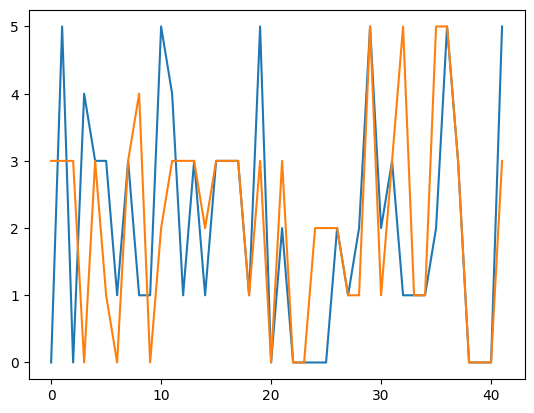

In [89]:
plt.plot(expert_dataset.trajectories["actions"][0])
plt.plot(test_action_trajs[0])

In [103]:
_test_acts_expert = np.array(expert_dataset.trajectories["actions"][0])
_test_acts_agent =  np.array(test_action_trajs[0])

np.sum(_test_acts_expert == _test_acts_agent) / len(_test_acts_expert)

0.5

In [104]:
def compute_action_accuracy(expert_dataset, agent):
    """
    Compute the action accuracy between expert and agent
    """

    agent_action_trajs = backtest_action_trajectory(expert_dataset, agent)

    accs = []
    for i in range(len(expert_dataset.trajectories["states"])):
        _test_acts_expert = np.array(expert_dataset.trajectories["actions"][i])
        _test_acts_agent =  np.array(agent_action_trajs[i])

        accs.append(np.sum(_test_acts_expert == _test_acts_agent) / len(_test_acts_expert))

    return accs